In [ ]:
# from google.colab import drive; drive.mount('/content/drive')   # OK to enable, if your kaggle.json is stored in Google Drive

In [ ]:
# !pip install unrar

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# !unrar x Desktop.rar

In [ ]:
!pip -q install --upgrade --force-reinstall --no-deps kaggle > log  # upgrade kaggle package (to avoid a warning)
!mkdir -p ~/.kaggle                                           # .kaggle folder must contain kaggle.json for kaggle executable to properly authenticate you to Kaggle.com
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json >log  # First, download kaggle.json from kaggle.com (in Account page) and place it in the root of mounted Google Drive
!cp kaggle.json ~/.kaggle/kaggle.json > log                   # Alternative location of kaggle.json (without a connection to Google Drive)
!chmod 600 ~/.kaggle/kaggle.json                              # give only the owner full read/write access to kaggle.json
!kaggle config set -n competition -v 17apr23ml-graphs         # set the competition context for the next few kaggle API calls. !kaggle config view - shows current settings
!kaggle competitions download >> log                          # download competition dataset as a zip file
!unzip -o *.zip >> log                                        # Kaggle dataset is copied as a single file and needs to be unzipped.
!kaggle competitions leaderboard --show                       # print public leaderboard

cp: cannot stat '/content/drive/MyDrive/kaggle.json': No such file or directory
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.9/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.9/dist-packages/kaggle/api/kaggle_api_extended.py", line 164, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.9/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.9/dist-pac

In [ ]:
%%time
%%capture
%reset -f
!pip -q install -U tensorflow_addons plotly > log   # update tfa in case students need to use it
from IPython.core.interactiveshell import InteractiveShell as IS; IS.ast_node_interactivity = "all" 
import numpy as np, pandas as pd, time, matplotlib.pyplot as plt, os, tqdm, re, sys, cv2, skimage
import tensorflow_addons as tfa, tensorflow as tf, tensorflow.keras as keras, tensorflow_datasets as tfds
from keras.layers import Flatten, Dense, Dropout, MaxPooling2D, Conv2D, Input
from keras.models import Sequential
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
ToCSV = lambda df, fname: df.round(2).to_csv(f'{fname}.csv', index_label='id') # rounds values to 2 decimals

class Timer():
  def __init__(self, lim:'RunTimeLimit'=60*5): self.t0, self.lim, _ = time.time(), lim, print(f'⏳ started. You have {lim} sec. Good luck!')
  def ShowTime(self):
    msg = f'Runtime is {time.time()-self.t0:.0f} sec'
    print(f'\033[91m\033[1m' + msg + f' > {self.lim} sec limit!!!\033[0m' if (time.time()-self.t0-1) > self.lim else msg)

np.set_printoptions(linewidth=100, precision=2, edgeitems=2, suppress=True)
pd.set_option('display.max_columns', 20, 'display.precision', 2, 'display.max_rows', 4)
tDIR, sDIR = 'trainXY/', 'testY/'

CPU times: user 5.92 s, sys: 949 ms, total: 6.87 s
Wall time: 1min 10s


Examples of graph images

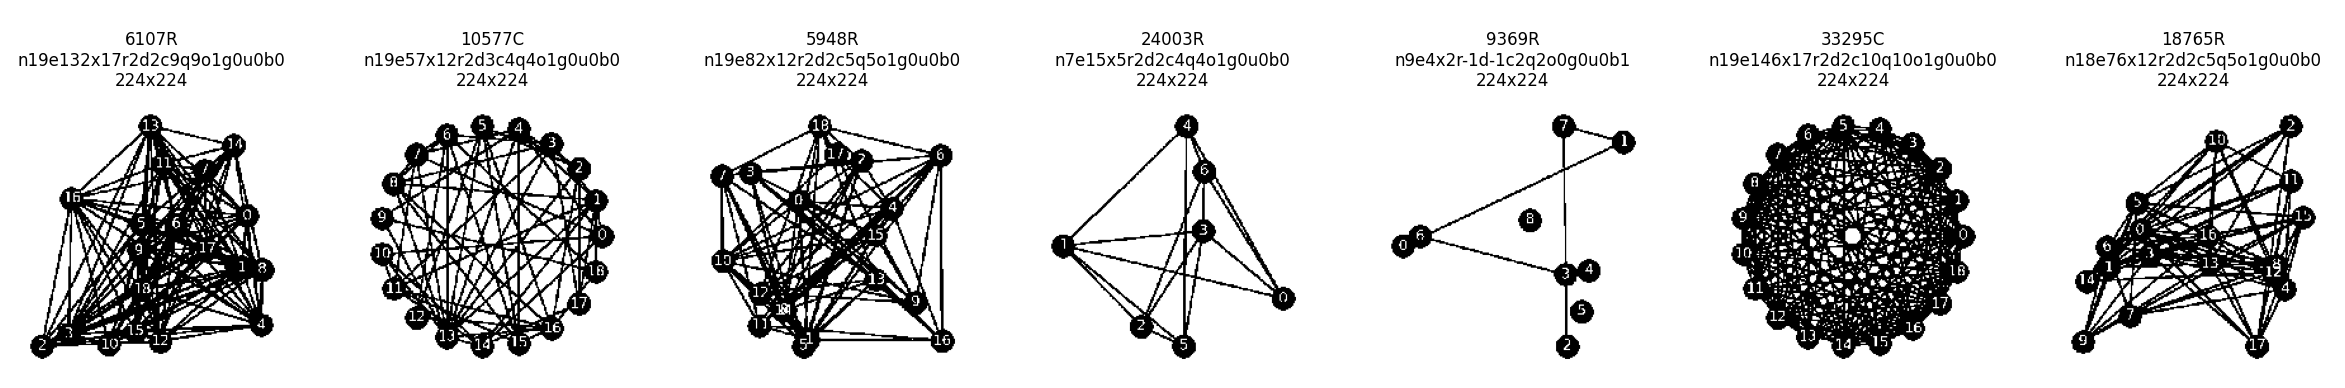

In [ ]:
n, fig = 7, plt.figure(figsize=(30,5));
for i, sFileName in enumerate(os.listdir(tDIR)[:n]):
  ax = plt.subplot(1, n, i + 1)
  img = tf.keras.preprocessing.image.load_img(tDIR + sFileName);
  sFileName = sFileName.replace("_","\n").replace(".png","")
  _ = ax.set_title(f'\n{sFileName}\n{img.size[0]}x{img.size[1]}');
  _ = plt.axis('off');   _ = plt.imshow(img);

In [ ]:
print(f'size of "tf" =', sys.getsizeof(tf)) # object size in bytes
np.iinfo(np.uint32)                         # use smallest possible data type to concerve RAM and speed up processing

size of "tf" = 72


iinfo(min=0, max=4294967295, dtype=uint32)

In [ ]:
# !nvidia-smi --query-gpu=gpu_name,memory.total,memory.free,memory.used --format=csv # GPU specs
!free   # assess free RAM ! Delete trash

              total        used        free      shared  buff/cache   available
Mem:       13297192      991964     5348132        2412     6957096    11999368
Swap:             0           0           0


In [ ]:
tmr = Timer() # runtime limit (in seconds). Add all of your code after the timer

⏳ started. You have 300 sec. Good luck!


<hr color=red>

<font size=5>⏳</font> <strong><font color=orange size=5>Your Code, Documentation, Ideas and Timer - All Start Here...</font></strong>

Students: Keep all your definitions, code, documentation **between** ⏳ symbols.

## **Task 1. Preprocessing Pipeline**
 
Explain elements of your preprocessing pipeline i.e. feature engineering, subsampling, clustering, dimensionality reduction, etc. 
1. Why did you choose these elements? (Something in EDA, prior experience,...? Btw, EDA is not required)
1. How do you evaluate the effectiveness of these elements? 
1. What else have you tried that worked or didn't? 

**Student's answer:**

## **Task 2. Modeling Approach**
Explain your modeling approach, i.e. ideas you tried and why you thought they would be helpful. 

1. How did these decisions guide you in modeling?
1. How do you evaluate the effectiveness of these elements? 
1. What else have you tried that worked or didn't? 

**Student's answer:**

<hr>

Next cell enables TPU in ~10-15 sec and offers 64GB RAM vs 12GB in Tesla K80 GPU. Your model might train faster. Ultimately it's your choice, so we leave it in the Student's Section.

In [ ]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')  # Source: https://www.tensorflow.org/guide/tpu
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)                   # TPU initialization code that has to be at the beginning.
print("All devices: ", tf.config.list_logical_devices('TPU'))

All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


TPU cannot use TF Datasets, but DataSets can load images via buffer, thereby freeing Colab's RAM. Loading method is your decision. FYI: with a dataset you need to keep track of the output labels.
 
 


In [ ]:
%%time
GetNums  = lambda sFilePath: list(map(np.int32, filter(None, re.split('[a-zA-Z_.]', os.path.basename(sFilePath)))))
ReadGray = lambda sFilePath: (cv2.imread(sFilePath, cv2.IMREAD_GRAYSCALE)/255).astype(np.uint8)
SplitY   = lambda nums: (nums[0], nums[1:])

nTrain = 10000
_, tY, tX = list(zip(*([(*SplitY(GetNums(tDIR+f)), ReadGray(tDIR+f)) for f in os.listdir(tDIR)[:nTrain]])))  # load labels and images from training folder
tX, tY = np.asarray(tX, dtype=np.uint8), np.asarray(tY, dtype=np.int16)[:,:7]   # you only need to predict first 7 fields

sIDs, sX = list(zip(*([(sDIR+f, ReadGray(sDIR+f)) for f in os.listdir(sDIR)]))) # load IDs and images from testing folder
sIDs = [int(re.sub('\D','',s)) for s in sIDs]                                   # extract just the numbers
sX = np.asarray(sX, dtype=np.uint8)

print('tX.shape:', tX.shape, 'tY.shape:', tY.shape, 'sX.shape:', sX.shape)

ValueError: ignored

It might be helpful to evaluate the distribution of graph attributes

In [ ]:
LsCols = ['n_nodes', 'e_edges', 'x_max_degrees', 'r_radius', 'd_diameter', 'c_cliques', 'q_max_clique']
pd.DataFrame(tY, columns=LsCols).hist(figsize=(40,3), layout=(1,7)); # Frequencies of different target levels may guide your CNN loss weigthing strategy

NameError: ignored

In [ ]:
!free   # keep an eye on your free RAM ! Delete trash

Below is a baseline model with many opportunities to improve it (and learn from it). You can choose a 7 dimensional dense layer as output or seven 1D outputs each of which can be fine-tuned separately.

In [ ]:
%%time
GetWeights = lambda v: v/sum(v) # computes loss importance to each output. Ensures sum(weights)=1
tf.random.set_seed(0)           # always seed your experiments
Init = keras.initializers.RandomNormal(seed=0) # always seed your experiments

I1 = keras.layers.Input(shape=[224, 224, 1], name='I1')   # input image size: spacial spatial and channels
C1 = Conv2D(filters=2, kernel_size=5, activation='relu', padding='same', kernel_initializer=Init, name='C1')(I1)
P1 = MaxPooling2D(pool_size=2, name='P1')(C1)
F1 = Flatten(name='F1')(P1)
D1 = Dense(100, activation='relu', kernel_initializer=Init, name='D1')(F1)
R1 = Dropout(0.2, name='R1')(D1)
O1 = Dense(len(LsCols), kernel_initializer=Init, name='O1')(R1)

# O1 = [Dense(1, activation=None, kernel_initializer=Init, name=c)(R1) for c in LsCols]  # creates individual outputs with individual loss weights
# loss_weights = dict(zip(LsCols, GetWeights(tY.mean(axis=0)*[1,2,1,1,1,1,1])))  # doubles the weight of target losses computed from target means

opt = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.99, beta_2=0.99, epsilon=1e-04, amsgrad=False, name='Adam',)
m = keras.Model(inputs=I1, outputs=O1)
m.compile(loss=['mse'], optimizer=opt)
keras.utils.plot_model(m, to_file='model.png', show_shapes=True, show_dtype=True, dpi=80)  # Double click the saved file to view the model
hist = m.fit(x=tX, y=tY, epochs=100, batch_size=1024, validation_split=0.2)

The distribution of output values may highlight problematic outputs (compare to training labels).

In [ ]:
pY = pd.DataFrame(m.predict(sX), columns=LsCols, index=sIDs)  # ensure that labels and observations are in corresponding order
_ = pY.hist(figsize=(40,3), layout=(1,11));
ToCSV(pY, '📍-baseline')
pY

# **References:**

1. Remember to cite your sources here as well! At the least, your textbook should be cited. Google Scholar allows you to effortlessly copy/paste an APA citation format for books and publications. Also cite StackOverflow, package documentation, and other meaningful internet resources to help your peers learn from these (and to avoid plagiarism claims).
1. ...
1. ...

<font size=5>⏳</font> <strong><font color=orange size=5>Do not exceed competition's runtime limit!</font></strong>


In [ ]:
tmr.ShowTime()    # measure Colab's runtime. Do not remove. Keep as the last cell in your notebook.

## 💡**Starter Ideas**

1. As usual, you can tune hyperparameters or network architecture to beat the baseline
1. Try individually weighted target losses. Recall: MSE is sensitive to extreme output values
1. Try more observations, but you'll need to optimize data structures and memory utilization
1. Try GPU vs TPU (to speed up processing more observations)
1. Evaluate which test cases have biggest damage to your model's performance
  1. Try more observations for most-damaging test cases
  1. Try image augmentation for most-damaging test cases
1. Try pre-trained model from Keras, TensorFlow, PyTorch
1. Try a different encoding of `-1` output values (for radius and diameter)
1. Try one hot encoding for outputs with fewer levels, such as radius
1. Learn about graph theory [&#127910;](https://www.youtube.com/results?search_query=graph+theory), grahical models [&#127910;](https://www.youtube.com/results?search_query=graphical+models), graph cliques [&#127910;](https://www.youtube.com/results?search_query=graph+cliques), social network graphs [&#127910;](https://www.youtube.com/results?search_query=social+networks+graphs), Undirected Graphical Models in [📔ESL17](https://hastie.su.domains/ElemStatLearn/printings/ESLII_print12.pdf#page=664)
1. *Algorithmic constraints*: try cleaning your predictions with constraints. 
  1. E.g. a graph with 0 edges must have zero in many other columns
  1. E.g. a graph respects [`e≤(n*(n-1)/2)`](https://en.wikipedia.org/wiki/Complete_graph), [`r≤d≤e`](https://en.wikipedia.org/wiki/Distance_(graph_theory)#Related_concepts), `x≤e`, [`q≤e`](https://en.wikipedia.org/wiki/Clique_(graph_theory))
1. *DNN constraints*: You can add these rules as outputs and even heavily penalize the model for violating constraints
      1. E.g. a binary target `(r≤d)*1` can be predicted with `Dense(1, 'sigmoid')` output and greater weight
1. Try using unused outputs (`o`, `g`, `u`, `b`) to tune model predictions of other columns
1. Try adding classical features (to CNN) built with [CV2](https://opencv.org), [SKLearn-image](https://scikit-image.org/)
  1. E.g. spectral representation, edge/circle/crossover/corner detectors, [HOG](https://en.wikipedia.org/wiki/Histogram_of_oriented_gradients)
1. Try file size, time stamp, and plot type (C,R,S,P) as extra input features
  1. Note: some competitions may disallow such features (as irrelevant)